# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import spacy
from spacy import displacy
from newsapi import NewsApiClient
from path import Path
import csv
import warnings
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
%matplotlib inline




Bad key savefig.frameon in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  #

In [2]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [3]:
# Function to create a dataframe for english news and french news
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

#this function writes the event data to a csv file to avoid calling the API multiple times
def write_csv(df,file_name):
    file_path = Path(file_name)
    df.to_csv(file_path, index=False, encoding='utf-8-sig')


# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)
#get the news using News Api client
def get_news(query,language,file_name,reload=False):
    complete_file_name = "./Resources/"+file_name
    path = Path(complete_file_name) 
    #if reload is specified as true, then do not read from old file
    if (path.exists() and reload == False):
        print(f'The file {complete_file_name} exists')
        news_df = pd.read_csv(complete_file_name)
    else:
        print(f'retreiving data from new API for query: {query}, and language:{language}')
        results = newsapi.get_everything(
                    q=query,
                    language=language
                )
        print(f'total results for query "{query}" in langyage:{language} are : {results["totalResults"]}')
        #convert the news articles to dataframe
        news_df = create_df(results["articles"], language)
        write_csv(news_df,complete_file_name)
    return news_df
    

In [4]:
#reload is set to false, so it will retreive the data from already existing csv file
#pls specify last argument as True to reload fresh data
bitcoin_news_en_df = get_news("bitcoin","en","Bitcoin_en.csv",False)
bitcoin_news_en_df.head()


The file ./Resources/Bitcoin_en.csv exists


,title,description,text,date,language
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10,en
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02,en
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16,en
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en


In [5]:
# Fetch the Ethereum news articles
#reload is set to false, so it will retreive the data from already existing csv file
#pls specify last argument as True to reload fresh data
ethereum_news_en_df = get_news("ethereum","en","Ethereum_en.csv",False)
ethereum_news_en_df.head()

The file ./Resources/Ethereum_en.csv exists


,title,description,text,date,language
0,Here's what NFTs look like on Instagram,Meta has revealed more of how NFTs will work o...,Meta has revealed more of how NFTs will work o...,2022-05-10,en
1,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en
2,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en
3,Cryptoverse: Ether prepares for epic 'merge' i...,Ether has promised to do better. It has promis...,April 26 (Reuters) - Ether has promised to do ...,2022-04-26,en
4,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26,en


In [6]:
#dictionary to store the sentiment scores of the article
text_sent = {
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "text_sent": [],
        }

analyzer = SentimentIntensityAnalyzer()
# Get sentiment for the text and the title
def get_sentiment_score(news_df):
    
    for index, row in news_df.iterrows():
        try:
            # Sentiment scoring with VADER
            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["text_compound"].append(text_sentiment["compound"])
            text_sent["text_pos"].append(text_sentiment["pos"])
            text_sent["text_neu"].append(text_sentiment["neu"])
            text_sent["text_neg"].append(text_sentiment["neg"])
            text_sent["text_sent"].append(text_sentiment["compound"])
        except AttributeError:
            pass
        
    return text_sent

    
# Attaching sentiment columns to the News DataFrame
text_sent = get_sentiment_score(bitcoin_news_en_df)
bitcoin_text_sentiment_df = pd.DataFrame(text_sent)
bitcoin_news_en_df = bitcoin_news_en_df.join(bitcoin_text_sentiment_df)
bitcoin_news_en_df.head()

,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10,en,0.0772,0.036,0.964,0.000,0.0772
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,-0.0516,0.056,0.882,0.061,-0.0516
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02,en,-0.3269,0.085,0.772,0.143,-0.3269
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16,en,0.3818,0.114,0.833,0.052,0.3818
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.3400,0.072,0.928,0.000,0.3400


In [7]:

# Attaching sentiment columns to the News DataFrame
text_sent = get_sentiment_score(ethereum_news_en_df)
ethereum_text_sentiment_df = pd.DataFrame(text_sent)
ethereum_news_en_df = ethereum_news_en_df.join(ethereum_text_sentiment_df)
ethereum_news_en_df.head()



,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent
0,Here's what NFTs look like on Instagram,Meta has revealed more of how NFTs will work o...,Meta has revealed more of how NFTs will work o...,2022-05-10,en,0.0772,0.036,0.964,0.000,0.0772
1,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en,-0.0516,0.056,0.882,0.061,-0.0516
2,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en,-0.3269,0.085,0.772,0.143,-0.3269
3,Cryptoverse: Ether prepares for epic 'merge' i...,Ether has promised to do better. It has promis...,April 26 (Reuters) - Ether has promised to do ...,2022-04-26,en,0.3818,0.114,0.833,0.052,0.3818
4,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26,en,0.3400,0.072,0.928,0.000,0.3400


In [8]:
bitcoin_text_sentiment_df.describe()

,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.00000,20.000000
mean,-0.093390,0.059450,0.860050,0.08045,-0.093390
std,0.389782,0.062439,0.104336,0.07613,0.389782
min,-0.859300,0.000000,0.557000,0.00000,-0.859300
25%,-0.366350,0.000000,0.827000,0.05350,-0.366350
50%,-0.190100,0.048000,0.888000,0.06300,-0.190100
75%,0.152575,0.085000,0.930250,0.08425,0.152575
max,0.750600,0.202000,0.964000,0.30000,0.750600


In [9]:
ethereum_text_sentiment_df.describe()

,text_compound,text_pos,text_neu,text_neg,text_sent
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-0.053582,0.056025,0.880025,0.063975,-0.053582
std,0.407572,0.068632,0.087538,0.063920,0.407572
min,-0.859300,0.000000,0.557000,0.000000,-0.859300
25%,-0.335475,0.000000,0.853000,0.000000,-0.335475
50%,-0.190100,0.042000,0.908500,0.063000,-0.190100
75%,0.237625,0.078250,0.937000,0.077000,0.237625
max,0.865500,0.269000,1.000000,0.300000,0.865500


### Questions:

Q: Which coin had the highest mean positive score?

A: ***Bitcoin has the hightest mean positive score of 0.059450***

Q: Which coin had the highest compound score?

A: ***Ethereum has the highest compound score of 0.865500***

Q. Which coin had the highest positive score?

A: ***Ethereum has the highest positive score of 0.269000***


---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [10]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

In [11]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    # Convert the words to lowercase
    # Remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    return tokens


In [12]:
# Create a new tokens column for Bitcoin
def generate_tokens(df):
    list_tokens=[]
    for row in df["text"]:
        tokens = tokenizer(row)
        list_tokens.append(tokens)
    return list_tokens

bitcoin_tokens = generate_tokens(bitcoin_news_en_df)
bitcoin_news_en_df['tokens'] = bitcoin_tokens
bitcoin_news_en_df.head()

,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10,en,0.0772,0.036,0.964,0.000,0.0772,"[even, though, number, womenfocused, crypto, s..."
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,-0.0516,0.056,0.882,0.061,-0.0516,"[bitcoin, mining, site, powered, otherwise, lo..."
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02,en,-0.3269,0.085,0.772,0.143,-0.3269,"[warren, buffett, ha, always, bitcoin, skeptic..."
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16,en,0.3818,0.114,0.833,0.052,0.3818,"[kid, remember, father, tried, use, broom, han..."
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.3400,0.072,0.928,0.000,0.3400,"[image, source, getty, imagesthe, value, bitco..."


In [13]:
# Create a new tokens column for Ethereum
ethereum_tokens = generate_tokens(ethereum_news_en_df)
ethereum_news_en_df['tokens'] = ethereum_tokens
ethereum_news_en_df.head()

,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Here's what NFTs look like on Instagram,Meta has revealed more of how NFTs will work o...,Meta has revealed more of how NFTs will work o...,2022-05-10,en,0.0772,0.036,0.964,0.000,0.0772,"[meta, ha, revealed, nfts, work, instagram, us..."
1,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en,-0.0516,0.056,0.882,0.061,-0.0516,"[multibillion, dollar, cryptocurrency, company..."
2,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en,-0.3269,0.085,0.772,0.143,-0.3269,"[bored, ape, yacht, club, creator, yuga, labs,..."
3,Cryptoverse: Ether prepares for epic 'merge' i...,Ether has promised to do better. It has promis...,April 26 (Reuters) - Ether has promised to do ...,2022-04-26,en,0.3818,0.114,0.833,0.052,0.3818,"[april, reuters, ether, ha, promised, better, ..."
4,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26,en,0.3400,0.072,0.928,0.000,0.3400,"[ethereum, preparing, upgrade, thats, describe..."


---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [14]:
#concat data from all the rows for tokens column
def get_big_token_string(df):
    big_str=''
    for row in df["tokens"]:
        list_string = ' '.join(row)
        big_str = big_str + list_string
    return big_str



In [15]:
# Generate the Bitcoin N-grams where N=2
big_string_bitcoin_tokens = get_big_token_string(bitcoin_news_en_df)
bitcoin_tokens = big_string_bitcoin_tokens.split()
bitcoin_bigram_counts = Counter(ngrams(bitcoin_tokens, n=2))

In [16]:
# Generate the Ethereum N-grams where N=2
big_string_ethereum_tokens = get_big_token_string(ethereum_news_en_df)
ethereum_tokens = big_string_ethereum_tokens.split()
ethereum_bigram_counts = Counter(ngrams(ethereum_tokens, n=2))

In [17]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [18]:
# Use token_count to get the top 10 words for Bitcoin
bitcoin_top_words = token_count(bitcoin_tokens,10)
print(bitcoin_top_words)

[('bitcoin', 12), ('cryptocurrency', 12), ('world', 7), ('ha', 5), ('week', 5), ('reuters', 5), ('investor', 4), ('dropped', 4), ('previous', 4), ('closebitcoin', 4)]


In [19]:
# Use token_count to get the top 10 words for Ethereum
ethereum_top_words = token_count(ethereum_tokens,10)
print(ethereum_top_words)

[('cryptocurrency', 9), ('bitcoin', 8), ('ha', 7), ('world', 7), ('biggest', 5), ('reuters', 5), ('last', 5), ('ethereum', 4), ('nft', 4), ('week', 4)]


---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

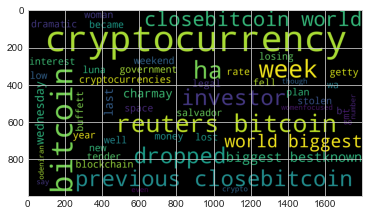

In [20]:
# Generate the Bitcoin word cloud
wc_bitcoin = WordCloud(width=1800, height=1000, max_words=50).generate(big_string_bitcoin_tokens)
plt.imshow(wc_bitcoin)



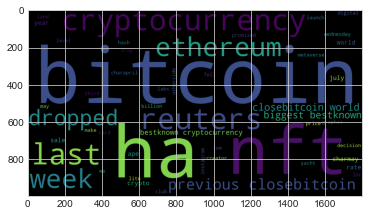

In [21]:
# Generate the Ethereum word cloud
wc_ethereum = WordCloud(width=1800, height=1000, max_words=50).generate(big_string_ethereum_tokens)
plt.imshow(wc_ethereum)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [22]:
# Download the language model for SpaCy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 15.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [24]:
# Concatenate all of the Bitcoin text together
def concat_news_data(df):
    big_str=''
    for row in df["text"]:
        list_string = ''.join(row)
        big_str = big_str + list_string
    return big_str

In [25]:
# Run the NER processor on all of the text
# Set article to be analyzed with spaCy
bitcoin_en_news_data = concat_news_data(bitcoin_news_en_df)
doc = nlp(bitcoin_en_news_data)
# Add a title to the document
doc.user_data["title"] = "Bitcoin Named Entity Recognition(NER)"

In [26]:
# Render NER visualization with displacy
displacy.render(doc, style='ent')

In [27]:
# List all Entities
print([ent.text for ent in doc.ents])

['Odeniran', 'Linden', 'Texas', 'April 4th, 2022', 'Photo', 'FRANCOIS PICARD/AFP', 'Getty Images', 'Buffett', 'the weekend', 'nearly three feet', 'Getty Images\r\n', 'the weekend', '34,000', '27,630', 'Coinbase', 'Last week', 'Fidelity Investments', 'the US Treasury', 'Bitcoin', 'Gucci handbag', 'week', 'Kristy Kilburn', 'May 11', 'Reuters', '7.23%', '28,758.29', 'GMT', 'Wednesday', '2,241.68', '40.4%', '+361 chars]May 4', 'Reuters', '5.7%', '39,862.84', 'Wednesday', '2,102.94', '20.9%', 'year', 'Reuters', '5.1%', '38,391.36', 'Tuesday', '2,229.82', '16%', 'year', 'last July', '33,000', 'the week', 'last week', 'Fed', '9', 'Reuters', '7.81%', '31,333.41', 'GMT', 'Monday', '2,655.98', '35%', 'Mexican', 'North London', 'a few weeks ago', '+2779 chars]May', '10', 'Reuters', 'chars]The Central African Republic', 'second', 'El Salvador', 'Wednesday', 'Faustin Archange', 'Touadera', 'two', "Seth Green's", 'Nike', 'Bankman-Fried', 'the digital asset exchange', 'FTX', 'first', 'September', '$3

In [28]:
displacy.render(doc, style='dep')

---

### Ethereum NER

In [29]:
# Concatenate all of the Ethereum text together
ethereum_all_en_news_data = concat_news_data(ethereum_news_en_df)


In [30]:
# Run the NER processor on all of the text
doc = nlp(ethereum_all_en_news_data)

# Add a title to the document
doc.user_data["title"] = "Ethereum Named Entity Recognition(NER)"

In [31]:
# Render the visualization
displacy.render(doc, style='ent')

In [32]:
# List all Entities
print([ent.text for ent in doc.ents])

['Meta', 'Instagram', 'US', 'Instagram', 'Ethereum', 'Yuga Labs', 'Yacht Club', 'Yuga Labs', 'Otherside NFT', 'April 30', 'NFT', 'chars]April 26', 'Reuters', 'No.2', 'second', 'Last night', 'Bloomberg', 'nearly a third', 'a billion dollars', 'IndependenceWe', 'chars]40 days ago', '47,454', '34,007', '28%.About a third', 'this week', 'Nvidia', 'Ampere Lite Hash Rate', 'LHR', 'Ethereum', '4', 'Reuters', '5.7%', '39,862.84', 'Wednesday', '2,102.94', '20.9%', 'year', 'Reuters', '5.1%', '38,391.36', 'Tuesday', '2,229.82', '16%', 'year', '+339 chars]May 11', 'Reuters', '7.23%', '28,758.29', 'GMT', 'Wednesday', '2,241.68', '40.4%', '+361 chars]May 9', 'Reuters', '7.81%', '31,333.41', 'GMT', 'Monday', '2,655.98', '35%', 'NFT', 'Ethereum', 'Last week', '8', 'Nvidia', 'LHR', 'last year\xa0', 'last July', '33,000', 'the week', 'last week', 'Fed', 'the past few years', 'NFT', '$29 billion', '16%', 'Monday', '14.60', 'Transform 2022', 'July 19 and virtually', 'July 20 - 28', 'today', 'Getty Images\

In [33]:
displacy.render(doc, style='dep')

---